1 → Fetches raw weather and pollutant data from an external API OpenWeather
https://openweathermap.org/api/air-pollution

In [ ]:
import requests
import csv
import datetime
import time
API = "ced66015f7438be60809c67c3c2876d4"  # OpenWeather API key
URL = "http://api.openweathermap.org/data/2.5/air_pollution/history?lat=24.8607&lon=67.0011&start={start}&end={end}&appid={API}"  # Karachi city coordinates
def fetch_data(api, s, e):
    url = URL.format(start=s, end=e, API=api)  #Format URL with correct start and end times
    resp = requests.get(url)
    if resp.status_code == 200:
        return resp.json()
    else:
        print(f"Error: {resp.status_code} - {resp.text}")  #Print error code and message
        return None
def time_from_date(date):
    return int(date.timestamp())
def fetch_data_util(api, s, days):
    response = []  #List to store collected data
    for i in range(days):
        start = s - datetime.timedelta(days=i + 1)  #Subtract i + 1 days to move backward in time
        end = s - datetime.timedelta(days=i)  #One day backward range
        start_time = time_from_date(start)
        end_time = time_from_date(end)
        print(f"Fetching data for: {end.strftime('%Y-%m-%d')} to {start.strftime('%Y-%m-%d')}")
        data = fetch_data(api, start_time, end_time)
        if data and "list" in data:  # Check if the data contains 'list' key
            for j in data["list"]:  # Loop through each entry in 'list'
                res = {
                    "date": datetime.datetime.fromtimestamp(j["dt"]).strftime("%Y-%m-%d %H:%M:%S"),
                    "aqi": j.get("main", {}).get("aqi"),
                    "pm25": j.get("components", {}).get("pm2_5"),
                    "pm10": j.get("components", {}).get("pm10"),
                    "no2": j.get("components", {}).get("no2"),
                    "o3": j.get("components", {}).get("o3"),
                }
                print(res)  # Print result for each entry
                response.append(res)  # Append to the response list
        time.sleep(1)  # Sleep to avoid rate limits
    return response
def save_in_csv(data, file_name):
    with open(file_name, mode="w", newline="") as file:
        w = csv.DictWriter(file, fieldnames=["date", "aqi", "pm25", "pm10", "no2", "o3"])
        w.writeheader()
        w.writerows(data)
if __name__ == "__main__":
    start_date = datetime.datetime.today()
    days = 365
    data = fetch_data_util(API, start_date, days)
    file_name = "aqi_data.csv"
    save_in_csv(data, file_name)
    print(f"AQI data saved to {file_name}")


2 → Computes features from this raw data
(aka model inputs), and targets (aka model
outputs)
Include time-based features (hour, day, month) and
derived features like AQI change rate.

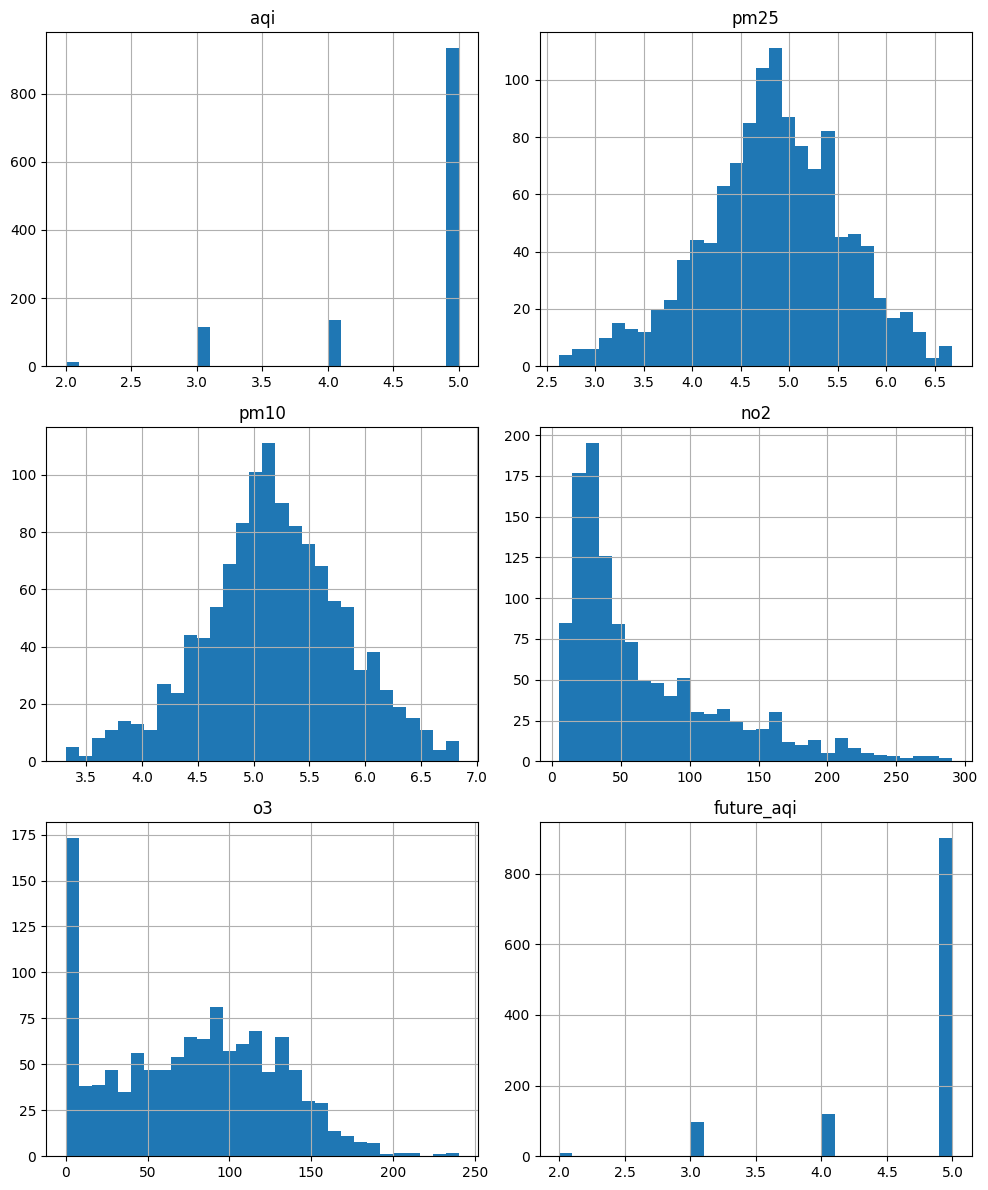

Processed model inputs and outputs saved to 'features_2023.csv'


<ipython-input-20-1abc8f1129eb>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)
<ipython-input-20-1abc8f1129eb>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['id'] = data.index + 1


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("/content/aqi_data.csv", parse_dates=["date"])
data.sort_values(by="date", inplace=True)
data.set_index("date", inplace=True)

# Define Target
data["future_aqi"] = data["aqi"].shift(-72)  # Shift AQI to create a future prediction target

# Replace -9999 with NaN and fill NaN values (except for 'future_aqi') with median
data.replace(-9999, np.nan, inplace=True)
features_to_fill = [col for col in data.columns if col != "future_aqi"]
data[features_to_fill] = data[features_to_fill].fillna(data[features_to_fill].median())

# Log-transform skewed data
data["pm25"] = np.log1p(data["pm25"])
data["pm10"] = np.log1p(data["pm10"])

# Detect and remove outliers using z-score
z_scores = np.abs(zscore(data[["pm25", "pm10"]]))  # Calculate z-scores
data = data[(z_scores < 3).all(axis=1)]  # Keep rows with z-scores < 3

# Plot histograms of features
data.hist(figsize=(10, 12), bins=30)
plt.tight_layout()
plt.show()

# Basic Features
data["hour"] = data.index.hour
data["day"] = data.index.day
data["month"] = data.index.month
data["day_of_week"] = data.index.dayofweek
data["is_weekend"] = data["day_of_week"].isin([5, 6]).astype(int)

# Derived Features
data["rolling_pm25_mean"] = data["pm25"].rolling(window=3).mean()
data["rolling_pm10_mean"] = data["pm10"].rolling(window=3).mean()
data["rolling_pm25_std"] = data["pm25"].rolling(window=3).std()
data["rolling_pm10_std"] = data["pm10"].rolling(window=3).std()

data["pm25_change"] = data["pm25"].diff()  # Change rate for PM2.5
data["pm10_change"] = data["pm10"].diff()  # Change rate for PM10

# Lag Features
data["lag_1_pm25"] = data["pm25"].shift(1)
data["lag_1_pm10"] = data["pm10"].shift(1)
data["lag_1_aqi"] = data["aqi"].shift(1)

# Interaction Features
data["pm25_pm10_ratio"] = data["pm25"] / (data["pm10"] + 1e-9)

# Drop rows with NaN in features but retain NaN in 'future_aqi'
feature_columns = [col for col in data.columns if col != "future_aqi"]
data = data.dropna(subset=feature_columns)

# Remove duplicates
data.drop_duplicates(inplace=True)

# Reset index and add 'id' column starting from 1
data.reset_index(drop=True, inplace=True)
data['id'] = data.index + 1

# Save the processed data to a CSV file
try:
    # Ensure that 'id' column is handled properly
    data.to_csv("features_2023.csv", index=False)
    print("Processed model inputs and outputs saved to 'features_2023.csv'")
except Exception as e:
    print(f"Error saving file: {e}")


## The code provided below just demonstrates the correlation of every attribute to all other attributes (done for analysis purposes)

In [ ]:
new_df = pd.read_csv("/content/features_2023.csv")
print(new_df.shape)

(1195, 22)


Feature Correlations with AQI:
aqi                  1.000000
lag_1_aqi            0.882413
pm25_pm10_ratio      0.798572
pm25                 0.767651
rolling_pm25_mean    0.742446
lag_1_pm25           0.733938
pm10                 0.733141
rolling_pm10_mean    0.711705
lag_1_pm10           0.703726
no2                  0.377759
pm25_change          0.094151
pm10_change          0.082441
future_aqi           0.053375
day                  0.010907
month                0.004813
id                   0.000577
rolling_pm10_std    -0.013948
hour                -0.014869
rolling_pm25_std    -0.071472
is_weekend          -0.153665
day_of_week         -0.201555
o3                  -0.246363
Name: aqi, dtype: float64


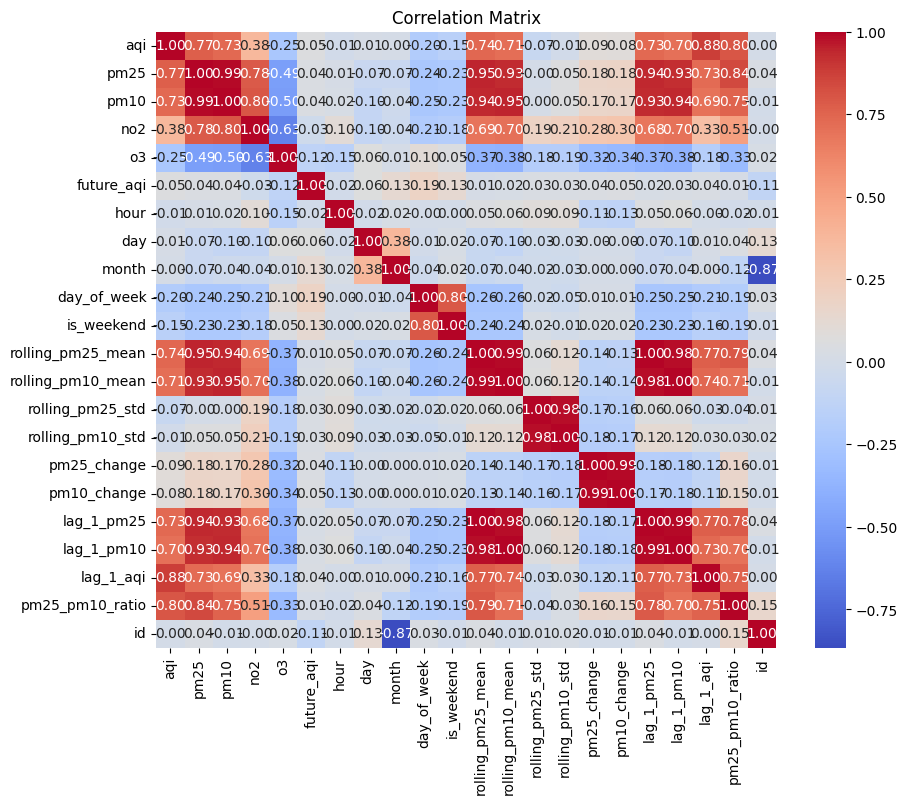

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("/content/features_2023.csv")
# Correlation Analysis
correlation_matrix = data.corr()
print("Feature Correlations with AQI:")
print(correlation_matrix["aqi"].sort_values(ascending=False))

# Visualize Correlation Matrix
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

3 →Stores these features in the Feature store
You may want to explore Hopsworks

##hopsworks

In [ ]:
!pip install -U 'hopsworks[python]' --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.6/258.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.5/640.5 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import hopsworks
from requests.exceptions import RequestException

In [ ]:
import pandas as pd
df = pd.read_csv('/content/features_2023.csv')
# df.set_index('id', inplace=True)
df

aqi      pm25      pm10    no2      o3  future_aqi  hour  day  month  \
0       3  3.222469  3.761898   9.34  101.57         4.0    11   13      1   
1       2  2.939691  3.609024  10.37   88.69         4.0    12   13      1   
2       2  3.045474  3.695110  25.02   67.95         4.0    13   13      1   
3       3  3.310908  3.891004  42.84   42.56         4.0    14   13      1   
4       3  3.536602  4.076690  46.61   33.97         4.0    15   13      1   
...   ...       ...       ...    ...     ...         ...   ...  ...    ...   
8613    5  5.226499  5.457754  80.20   11.80         NaN     4   12      1   
8614    5  5.327585  5.566817  84.31   32.19         NaN     5   12      1   
8615    5  5.411914  5.654382  93.22   63.66         NaN     6   12      1   
8616    4  3.942552  4.489198  15.42  133.04         NaN     7   12      1   
8617    4  3.711619  4.290596   8.65  140.19         NaN     8   12      1   

      day_of_week  ...  rolling_pm10_mean  rolling_pm25_std  rolling_pm10_std  \
0               5  ...           4.108502          0.519560          0.367736   
1               5  ...           3.813430          0.386710          0.234459   
2               5  ...           3.688677          0.142876          0.076639   
3               5  ...           3.731713          0.191245          0.144509   
4               5  ...           3.887601          0.245832          0.190813   
...           ...  ...                ...               ...               ...   
8613            6  ...           5.286669          0.215608          0.190528   
8614            6  ...           5.448494          0.122145          0.123214   
8615            6  ...           5.559651          0.092834          0.098510   
8616            6  ...           5.236799          0.825071          0.648920   
8617            6  ...           4.811392          0.922258          0.736773   

      pm25_change  pm10_change  lag_1_pm25  lag_1_pm10  lag_1_aqi  \
0       -0.482037    -0.307471    3.704507    4.069369        3.0   
1       -0.282778    -0.152873    3.222469    3.761898        3.0   
2        0.105783     0.086086    2.939691    3.609024        2.0   
3        0.265434     0.195894    3.045474    3.695110        2.0   
4        0.225694     0.185686    3.310908    3.891004        3.0   
...           ...          ...         ...         ...        ...   
8613     0.142056     0.136844    5.084443    5.320910        5.0   
8614     0.101086     0.109063    5.226499    5.457754        5.0   
8615     0.084329     0.087566    5.327585    5.566817        5.0   
8616    -1.469362    -1.165184    5.411914    5.654382        5.0   
8617    -0.230933    -0.198602    3.942552    4.489198        4.0   

      pm25_pm10_ratio    id  
0            0.856607     1  
1            0.814539     2  
2            0.824190     3  
3            0.850914     4  
4            0.867518     5  
...               ...   ...  
8613         0.957628  8614  
8614         0.957025  8615  
8615         0.957119  8616  
8616         0.878231  8617  
8617         0.865059  8618  

[8618 rows x 22 columns]

In [ ]:
def store_data(df):
    if df.empty:
        print("No data to upload to the Feature Store.")
        return

    # Login to Hopsworks
    project = hopsworks.login(api_key_value="CfEguTsh4ZmL50zX.XacymCLSjFjetGdkZ5kGRr5RMu4cMe0NVT7zFQKLE2E8pjsilqVhLbFZOj3YX3CE")
    fs = project.get_feature_store()

    # Create a unique name for the feature group
    new_feature_group_name = f"air_quality_features_f_3"

    # Create and insert data into the feature group
    try:
        feature_group = fs.create_feature_group(
            name=new_feature_group_name,
            version=1,
            description="Air quality features",
            primary_key=['id'],
            online_enabled=False
        )
        feature_group.insert(df)
        print(f"New feature group '{new_feature_group_name}' created and data inserted successfully!")
    except Exception as e:
        print(f"Failed to update the Feature Store: {e}")

store_data(df)


Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1209504
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1209504/fs/1197137/fg/1398206


Uploading Dataframe: 100.00% |██████████| Rows 1195/1195 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: air_quality_features_f_3_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1209504/jobs/named/air_quality_features_f_3_1_offline_fg_materialization/executions
New feature group 'air_quality_features_f_3' created and data inserted successfully!


# Training Pipeline
1 → Fetches historical (features, targets)from
the Feature Store.

In [ ]:
import hopsworks
def fetch_historical_data():
    project = hopsworks.login(api_key_value="CfEguTsh4ZmL50zX.XacymCLSjFjetGdkZ5kGRr5RMu4cMe0NVT7zFQKLE2E8pjsilqVhLbFZOj3YX3CE")
    fs = project.get_feature_store()
    feature_group_name = "air_quality_features_f_3"
    feature_group_version = 1

    try:
        # Retrieve data from the feature group
        feature_group = fs.get_feature_group(name=feature_group_name, version=feature_group_version)
        historical_data = feature_group.read()
        print("Fetched historical data successfully!")
        return historical_data
    except Exception as e:
        print(f"Failed to fetch historical data: {e}")
        return None

In [ ]:
historical_data = fetch_historical_data()
if historical_data is not None:
    print(historical_data.head())  # Display the first few rows


Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1209504
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.51s) 
Fetched historical data successfully!
   aqi      pm25      pm10     no2      o3  future_aqi  hour  day  month  \
0    5  4.444532  4.838422   37.01  114.44         5.0    14   12      1   
1    5  5.698234  5.903289  183.70   57.22         3.0    12   20      1   
2    5  5.847392  6.065412  154.91    0.00         5.0    20   11      1   
3    3  3.864931  4.290322   35.99   82.97         5.0     6    8     12   
4    5  6.205709  6.411013  211.12   39.70         5.0     6    8      1   

   day_of_week  ...  rolling_pm10_mean  rolling_pm25_std  rolling_pm10_std  \
0            6  ...           4.829831          0.007088          0.012811   
1            0  ...           5.716242          0.242695          0.229745   
2            5  ...           6.101913          0.098505          0.090480   
3            6  ...        

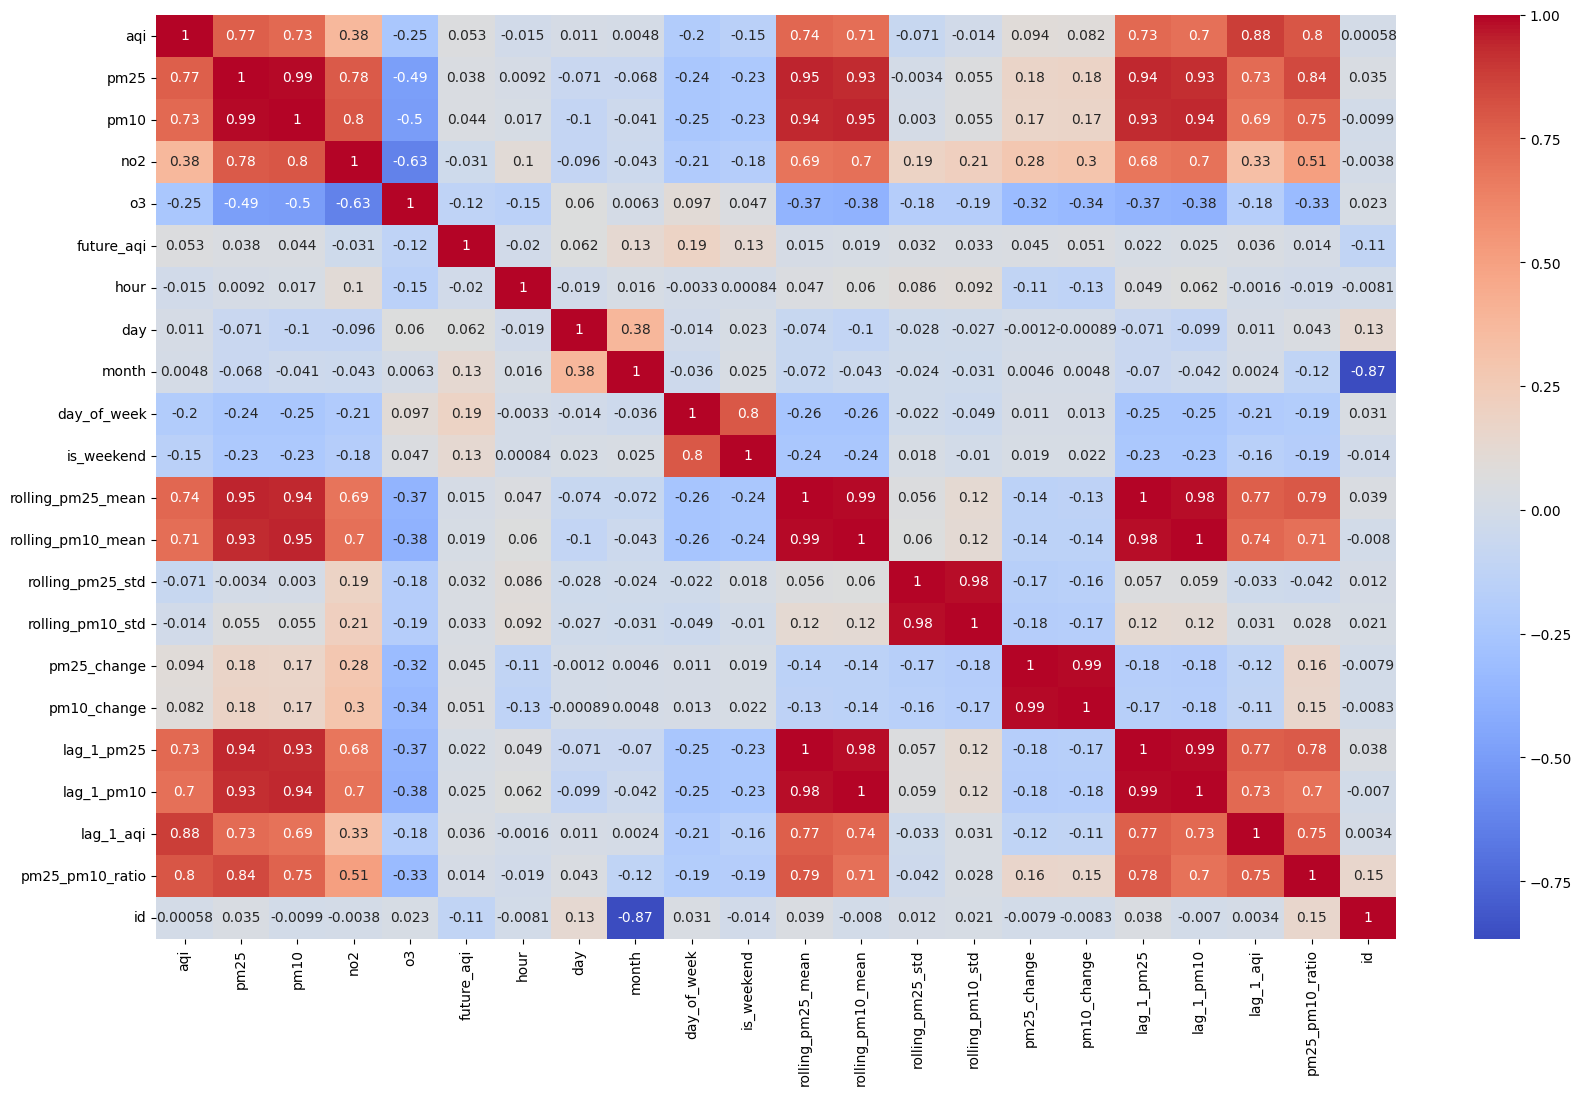

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 12))
sns.heatmap(historical_data.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
historical_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1123 entries, 0 to 1194
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   aqi                1123 non-null   int64  
 1   pm25               1123 non-null   float64
 2   pm10               1123 non-null   float64
 3   no2                1123 non-null   float64
 4   o3                 1123 non-null   float64
 5   future_aqi         1123 non-null   float64
 6   hour               1123 non-null   int64  
 7   day                1123 non-null   int64  
 8   month              1123 non-null   int64  
 9   day_of_week        1123 non-null   int64  
 10  is_weekend         1123 non-null   int64  
 11  rolling_pm25_mean  1123 non-null   float64
 12  rolling_pm10_mean  1123 non-null   float64
 13  rolling_pm25_std   1123 non-null   float64
 14  rolling_pm10_std   1123 non-null   float64
 15  pm25_change        1123 non-null   float64
 16  pm10_change        1123 non-n

In [ ]:
print("Shape of historical data without removing NaN values:", historical_data.shape)
testing_data = historical_data[historical_data['future_aqi'].isna()]
historical_data.dropna(inplace=True)
testing_data.to_csv("testing_data.csv", index=False)
print("Shape of historical data after removing NaN values: ", historical_data.shape)
print("Shape of testing data: ", testing_data.shape)

Shape of historical data without removing NaN values: (1123, 22)
Shape of historical data after removing NaN values:  (1123, 22)
Shape of testing data:  (0, 22)


In [ ]:
historical_data.to_csv('training_data', index=False)

2 → Trains and evaluate the best ML model
possible for this data
Experiment with Scikit-learn models (Random Forest, Ridge Regression) and
TensorFlow/PyTorch for advanced models.
Evaluate performance using RMSE, MAE, and R².


# Logistic Regression

In [ ]:
df1 = historical_data.copy()

def correlation(dataset, threshold):

    col_corr = set()

    numeric_df = dataset.select_dtypes(include=['int64', 'float64'])

    corr_matrix = numeric_df.corr()

    for i in range(len(corr_matrix.columns)):

        for j in range(i):

            if abs(corr_matrix.iloc[i, j]) < threshold:

                colname = corr_matrix.columns[i]

                if colname != 'future_aqi':

                  col_corr.add(colname)

    return col_corr



corrfeatures = correlation(df1, 0.05)

print(corrfeatures)

len(set(corrfeatures))

{'lag_1_pm10', 'id', 'day', 'lag_1_pm25', 'rolling_pm25_mean', 'hour', 'rolling_pm10_mean', 'pm25_change', 'pm25_pm10_ratio', 'month', 'rolling_pm25_std', 'rolling_pm10_std', 'is_weekend', 'pm10_change', 'lag_1_aqi', 'day_of_week'}


16

In [ ]:
df1.drop(columns=corrfeatures, inplace=True)

In [ ]:
import hopsworks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import numpy as np

if df1 is not None:
    # Preprocessing
    X = df1.drop(["future_aqi", "id"], axis=1, errors="ignore")  # Drop target and ID
    y = df1["future_aqi"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

    # Train Linear Regression Model
    linear_model = LogisticRegression()
    linear_model.fit(X_train, y_train)

    train_predictions = linear_model.predict(X_train)
    test_predictions = linear_model.predict(X_test)

    # Evaluate on the test set
    accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions, average="weighted")  # Weighted for multiclass
    recall = recall_score(y_test, test_predictions, average="weighted")
    f1 = f1_score(y_test, test_predictions, average="weighted")

    # Display metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Classification report (optional, for a detailed view per class)
    print("\nClassification Report:")
    print(classification_report(y_test, test_predictions))

    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, test_predictions)
    print(cm)
else:
    print("No data available for training.")

Accuracy: 0.7911
Precision: 0.7372
Recall: 0.7911
F1 Score: 0.7030

Classification Report:
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         3
         3.0       1.00      0.04      0.07        26
         4.0       0.00      0.00      0.00        19
         5.0       0.79      1.00      0.88       177

    accuracy                           0.79       225
   macro avg       0.45      0.26      0.24       225
weighted avg       0.74      0.79      0.70       225


Confusion Matrix:
[[  0   0   0   3]
 [  0   1   0  25]
 [  0   0   0  19]
 [  0   0   0 177]]


STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


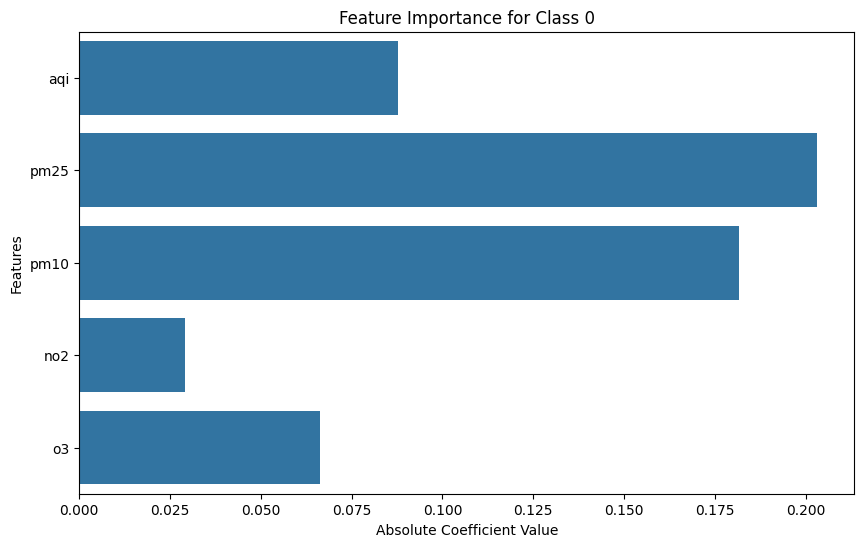

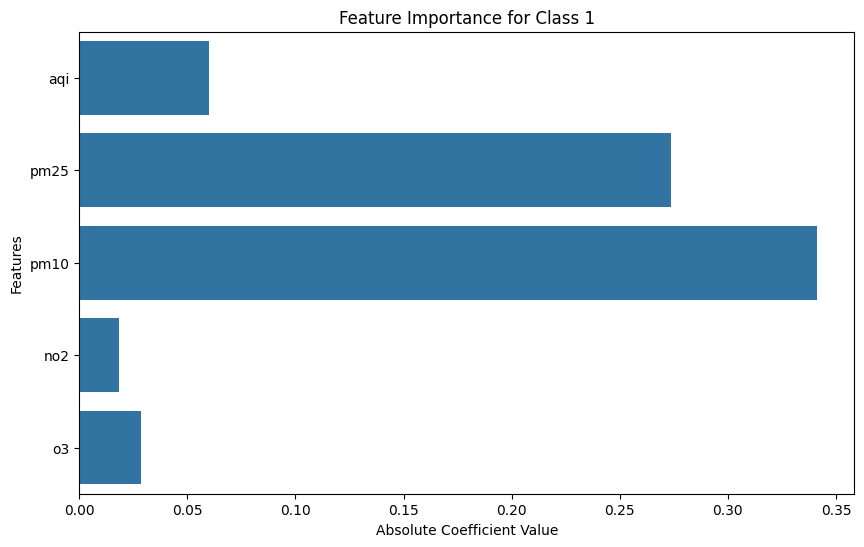

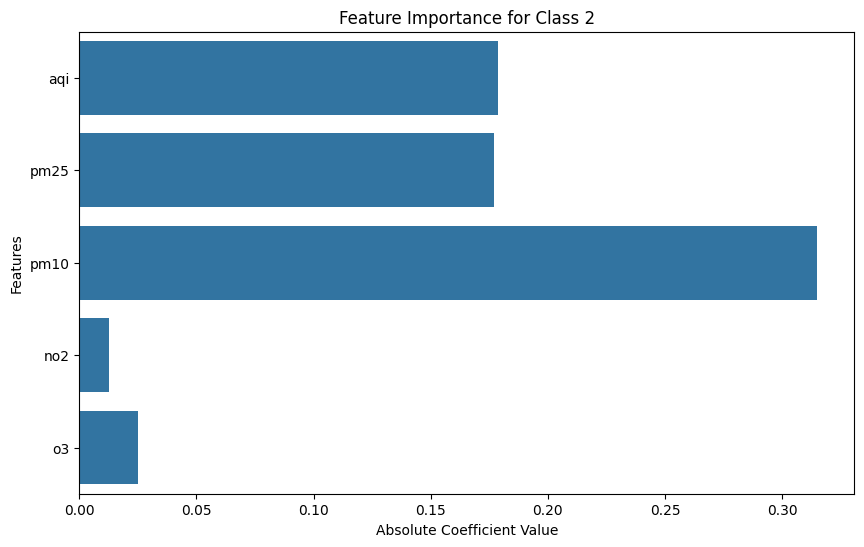

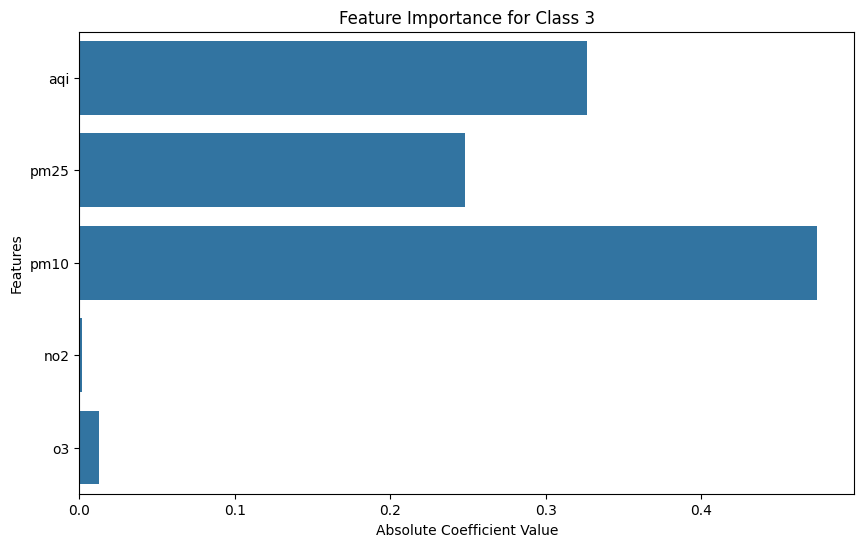

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get the absolute value of coefficients for each class
coef = linear_model.coef_

# Plot feature importance for each class
for class_index in range(coef.shape[0]):
    # Sort features by their importance
    importance = np.abs(coef[class_index])
    feature_names = X_train.columns

    # Create a bar plot for feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance, y=feature_names)
    plt.title(f"Feature Importance for Class {class_index}")
    plt.xlabel("Absolute Coefficient Value")
    plt.ylabel("Features")
    plt.show()


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5f717889b9cb2fabd267055f6f1ee8d072256faf56a272bc84c5f3043a696513
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Get the feature names
feature_names = list(X_train.columns)

# Create a LIME explainer for classification models
explainer = LimeTabularExplainer(
    training_data=X_train.to_numpy(),  # Use .to_numpy() instead of .values
    feature_names=feature_names,       # Provide the feature names
    mode='classification',             # Specify it's for classification
    discretize_continuous=True         # Discretize continuous variables
)

# Select an instance from the test set to explain
instance = X_test.iloc[0].values  # Select an instance for explanation

# Explain the model's prediction for the selected instance
exp = explainer.explain_instance(instance, linear_model.predict_proba)

# Show the explanation in a notebook
exp.show_in_notebook()


# Ridge Regression

In [ ]:
from math import sqrt
import hopsworks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import numpy as np


if df1 is not None:
    # Preprocessing
    X = df1.drop(["future_aqi", "id"], axis=1, errors="ignore")  # Drop target and ID
    y = df1["future_aqi"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

    alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Store results
results = []

# Iterate through each alpha and fit the Ridge model
for alpha in alphas:
    model = RidgeClassifier(alpha=alpha)
    model.fit(X_train, y_train)

    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Evaluate on the test set
    print("Evaluation for alpha value : ", alpha)
    print("\n\n")
    accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions, average="weighted")  # Weighted for multiclass
    recall = recall_score(y_test, test_predictions, average="weighted")
    f1 = f1_score(y_test, test_predictions, average="weighted")

    # Display metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Classification report (optional, for a detailed view per class)
    print("\nClassification Report:")
    print(classification_report(y_test, test_predictions))

    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, test_predictions)
    print(cm)
else:
    print("No data available for training.")

Evaluation for alpha value :  0.001



Accuracy: 0.7911
Precision: 0.7372
Recall: 0.7911
F1 Score: 0.7030

Classification Report:
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         3
         3.0       1.00      0.04      0.07        26
         4.0       0.00      0.00      0.00        19
         5.0       0.79      1.00      0.88       177

    accuracy                           0.79       225
   macro avg       0.45      0.26      0.24       225
weighted avg       0.74      0.79      0.70       225


Confusion Matrix:
[[  0   0   0   3]
 [  0   1   0  25]
 [  0   0   0  19]
 [  0   0   0 177]]
Evaluation for alpha value :  0.01



Accuracy: 0.7911
Precision: 0.7372
Recall: 0.7911
F1 Score: 0.7030

Classification Report:
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         3
         3.0       1.00      0.04      0.07        26
         4.0       0.00      0.00      0.00    

Evaluation for alpha value :  1000



Accuracy: 0.7911
Precision: 0.7372
Recall: 0.7911
F1 Score: 0.7030

Classification Report:
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         3
         3.0       1.00      0.04      0.07        26
         4.0       0.00      0.00      0.00        19
         5.0       0.79      1.00      0.88       177

    accuracy                           0.79       225
   macro avg       0.45      0.26      0.24       225
weighted avg       0.74      0.79      0.70       225


Confusion Matrix:
[[  0   0   0   3]
 [  0   1   0  25]
 [  0   0   0  19]
 [  0   0   0 177]]
No data available for training.


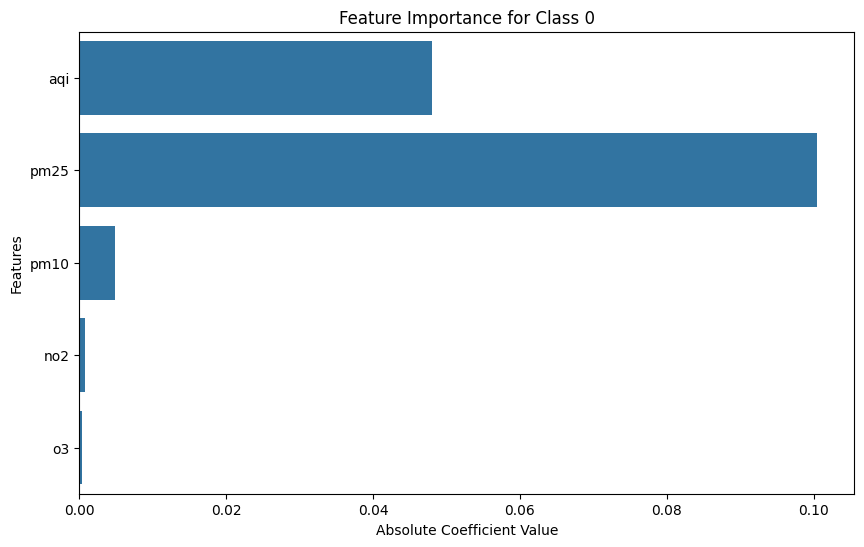

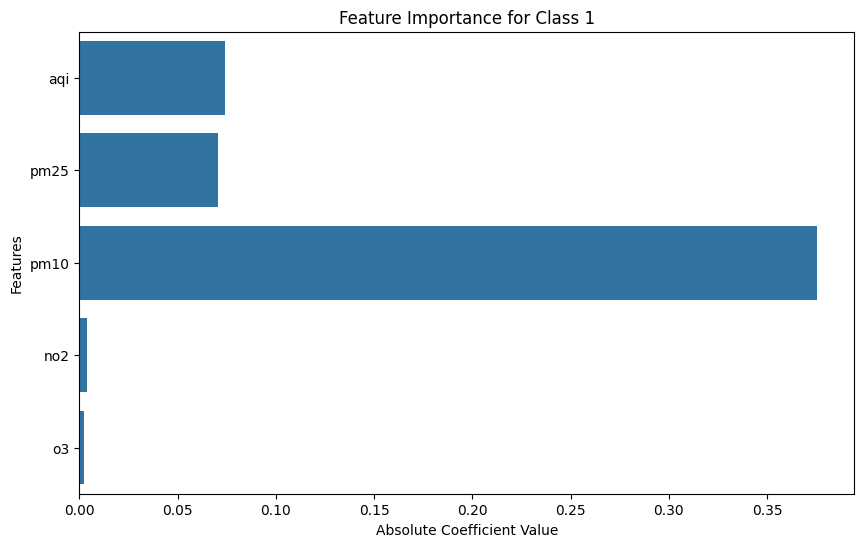

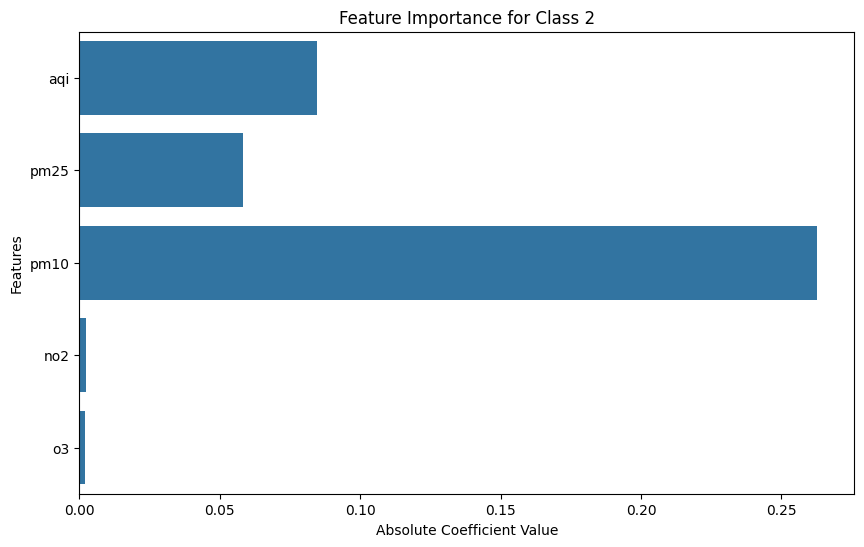

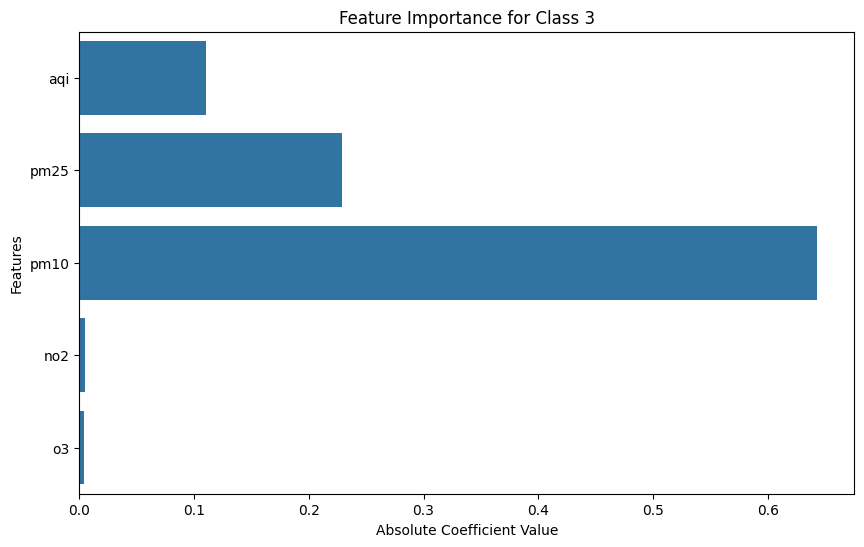

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import RidgeClassifier
from lime.lime_tabular import LimeTabularExplainer

# Create the RidgeClassifier model and fit it
ridge_classifier = RidgeClassifier(alpha=1.0)
ridge_classifier.fit(X_train, y_train)

# Get the absolute value of coefficients for each class
coef = ridge_classifier.coef_

# Plot feature importance for each class
for class_index in range(coef.shape[0]):
    # Sort features by their importance
    importance = np.abs(coef[class_index])
    feature_names = X_train.columns

    # Create a bar plot for feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance, y=feature_names)
    plt.title(f"Feature Importance for Class {class_index}")
    plt.xlabel("Absolute Coefficient Value")
    plt.ylabel("Features")
    plt.show()


#Random Forest

In [ ]:
import hopsworks
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from math import sqrt
import numpy as np


if df1 is not None:

    # Preprocessing
    X = df1.drop(["future_aqi", "id"], axis=1, errors="ignore")  # Drop target and ID
    y = df1["future_aqi"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=300,  # Number of trees in the forest
        max_depth=8,    # Maximum depth of each tree
        random_state=42    # Seed for reproducibility
    )

    # Train the model
    rf_model.fit(X_train, y_train)

    # Predict on test data
    train_predictions = rf_model.predict(X_train)
    test_predictions = rf_model.predict(X_test)

    # Evaluate on the test set
    accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions, average="weighted")  # Weighted for multiclass
    recall = recall_score(y_test, test_predictions, average="weighted")
    f1 = f1_score(y_test, test_predictions, average="weighted")

    # Display metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Classification report (optional, for a detailed view per class)
    print("\nClassification Report:")
    print(classification_report(y_test, test_predictions))

    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, test_predictions)
    print(cm)
else:
    print("No data available for training.")



Accuracy: 0.7911
Precision: 0.7825
Recall: 0.7911
F1 Score: 0.7229

Classification Report:
              precision    recall  f1-score   support

         2.0       0.00      0.00      0.00         3
         3.0       1.00      0.04      0.07        26
         4.0       0.43      0.16      0.23        19
         5.0       0.80      0.98      0.88       177

    accuracy                           0.79       225
   macro avg       0.56      0.29      0.30       225
weighted avg       0.78      0.79      0.72       225


Confusion Matrix:
[[  0   0   0   3]
 [  0   1   1  24]
 [  0   0   3  16]
 [  0   0   3 174]]


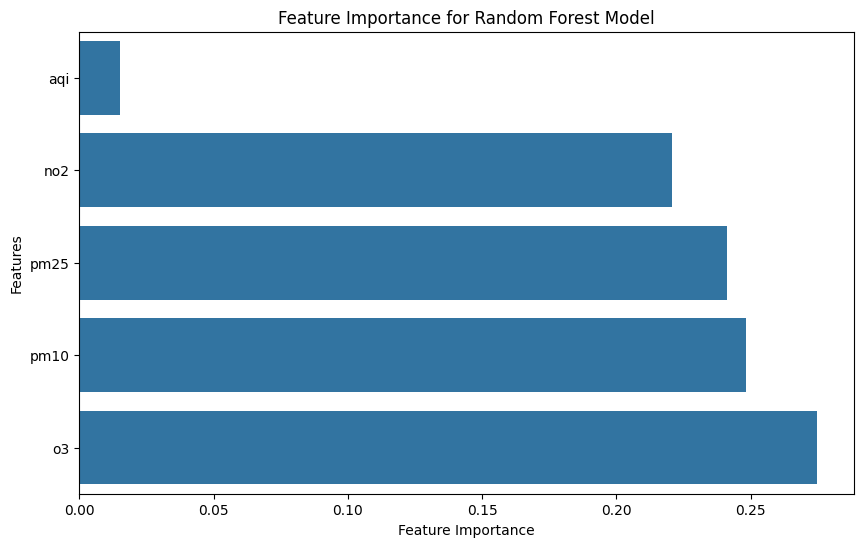

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from lime.lime_tabular import LimeTabularExplainer

# Assuming rf_model is your already trained Random Forest model
# Get feature importance
importance = rf_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importance[sorted_idx], y=feature_names[sorted_idx])
plt.title("Feature Importance for Random Forest Model")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

# LIME for Random Forest Model
# Create a LIME explainer for classification models
explainer = LimeTabularExplainer(
    training_data=X_train.to_numpy(),  # Use .to_numpy() instead of .values
    feature_names=feature_names,       # Provide the feature names
    mode='classification',             # Specify it's for classification
    discretize_continuous=True         # Discretize continuous variables
)

# Select an instance from the test set to explain
instance = X_test.iloc[0].values  # Select an instance for explanation

# Explain the model's prediction for the selected instance
exp = explainer.explain_instance(instance, rf_model.predict_proba)

# Show the explanation in a notebook
exp.show_in_notebook()


##Creating model files in directory and regestring them to Hopswork

In [ ]:
import os
import joblib

In [ ]:
# Specify the model directory
model_dir = "pickle_models"
# Create directories if they don't exist
os.makedirs(model_dir, exist_ok=True)


In [ ]:
import hopsworks
project = hopsworks.login(api_key_value="CfEguTsh4ZmL50zX.XacymCLSjFjetGdkZ5kGRr5RMu4cMe0NVT7zFQKLE2E8pjsilqVhLbFZOj3YX3CE")
mr = project.get_model_registry()

Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1209504


In [ ]:
#exporting logistic regression model to model dir
linear_model_path = os.path.join(model_dir, "linear_model.pkl")
joblib.dump(model, linear_model_path)

['pickle_models/linear_model.pkl']

In [ ]:
#exporting random forest regression model to model dir
rf_model_path = os.path.join(model_dir, "rf_model.pkl")
joblib.dump(rf_model, rf_model_path)

['pickle_models/rf_model.pkl']

In [ ]:
for model_file in [linear_model_path, rf_model_path]:
    # Check if the file has the correct extension
    if not model_file.endswith(".pkl"):
        raise ValueError(f"Invalid file format: {model_file}. Only .pkl files are supported.")

    # Add a version suffix to the model name
    model_name = os.path.splitext(os.path.basename(model_file))[0] + "_v3"

    # Create and register the model in Hopsworks
    hopsworks_model = mr.python.create_model(
        name=model_name,
        description=f"Model {model_name} for AQI prediction"
    )
    hopsworks_model.save(model_file)  # Upload the `.pkl` file
    print(f"Registered and uploaded model: {model_name}")


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/2128 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1209504/models/linear_model_v3/1
Registered and uploaded model: linear_model_v3


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/4712745 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1209504/models/rf_model_v3/1
Registered and uploaded model: rf_model_v3


Loading the model from hopsworks registry

In [ ]:
import hopsworks

project = hopsworks.login(api_key_value="CfEguTsh4ZmL50zX.XacymCLSjFjetGdkZ5kGRr5RMu4cMe0NVT7zFQKLE2E8pjsilqVhLbFZOj3YX3CE")
mr = project.get_model_registry()

# Directory to store the retrieved models
retrieved_model_dir = "retrieved_models"
os.makedirs(retrieved_model_dir, exist_ok=True)

# List of model names to retrieve
model_names = ["linear_model_v3", "rf_model_v3"]  # Versioned names
model_version = 1  # Specify the version of the models to retrieve

# Loop through model names and download them
for model_name in model_names:
    print(f"Retrieving model: {model_name} (version {model_version})")

    # Get the model from Hopsworks
    model = mr.get_model(model_name, version=model_version)

    # Download the model to the local directory
    model_dir = model.download(retrieved_model_dir)
    print(f"Model '{model_name}' downloaded to: {model_dir}")

    # Load the model using joblib
    model_file_path = os.path.join(model_dir, f"{model_name}.pkl")
    if os.path.exists(model_file_path):
        loaded_model = joblib.load(model_file_path)
        print(f"Model '{model_name}' loaded successfully!")
    else:
        print(f"Model file '{model_file_path}' not found!")

Connection closed.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1209504
Retrieving model: linear_model_v3 (version 1)
Model 'linear_model_v3' downloaded to: retrieved_models
Model file 'retrieved_models/linear_model_v3.pkl' not found!
Retrieving model: rf_model_v3 (version 1)
Model 'rf_model_v3' downloaded to: retrieved_models
Model file 'retrieved_models/rf_model_v3.pkl' not found!


In [ ]:
retrieved_model_dir = "retrieved_models"

model_name = "rf_model"

# Path to the model file
model_file_path = os.path.join(retrieved_model_dir, f"{model_name}.pkl")

# Load the model if it exists
if os.path.exists(model_file_path):
    rf_model = joblib.load(model_file_path)
    print(f"Random Forest model '{model_name}' loaded successfully!")
else:
    print(f"Model file '{model_file_path}' not found!")

Random Forest model 'rf_model' loaded successfully!


In [ ]:
test_df = pd.read_csv('testing_data.csv')
test_df

aqi      pm25      pm10     no2      o3  future_aqi  hour  day  month  \
0     4  4.006060  4.378646   30.16   77.25         NaN     5   25      1   
1     5  5.151730  5.434115   74.71    0.91         NaN    18   25      1   
2     3  3.017983  3.783053    6.00  135.90         NaN     9   25      1   
3     5  4.655578  4.984702  105.56   24.68         NaN    14   25      1   
4     3  3.278653  3.800197   12.34   82.97         NaN     1   24      1   
..  ...       ...       ...     ...     ...         ...   ...  ...    ...   
67    4  4.010963  4.412192   26.39   84.40         NaN    19   24      1   
68    3  2.658860  3.350956    8.74  118.73         NaN    11   23      1   
69    4  4.111529  4.441592   39.41   60.80         NaN     4   25      1   
70    3  3.013081  3.781914    5.57  134.47         NaN     8   25      1   
71    5  4.375254  4.761917   30.85  158.79         NaN     7   26      1   

    day_of_week  ...  rolling_pm10_mean  rolling_pm25_std  rolling_pm10_std  \
0             5  ...           4.401005          0.052774          0.035210   
1             5  ...           5.538442          0.110121          0.090437   
2             5  ...           3.811778          0.056111          0.050743   
3             5  ...           4.447346          0.724384          0.517541   
4             4  ...           3.713032          0.122122          0.080306   
..          ...  ...                ...               ...               ...   
67            4  ...           4.642627          0.244336          0.206764   
68            3  ...           3.366440          0.064758          0.056882   
69            5  ...           4.327281          0.178921          0.149967   
70            5  ...           3.957900          0.410500          0.232459   
71            6  ...           5.316852          0.585017          0.482598   

    pm25_change  pm10_change  lag_1_pm25  lag_1_pm10  lag_1_aqi  \
0     -0.105470    -0.062946    4.111529    4.441592        4.0   
1     -0.179829    -0.152534    5.331559    5.586649        5.0   
2      0.004902     0.001138    3.013081    3.781914        3.0   
3      0.753605     0.579569    3.901973    4.405133        3.0   
4      0.159819     0.103350    3.118834    3.696848        2.0   
..          ...          ...         ...         ...        ...   
67    -0.345489    -0.291556    4.356452    4.703748        5.0   
68     0.026252     0.032054    2.632608    3.318902        3.0   
69     0.056272     0.058816    4.055257    4.382776        4.0   
70    -0.099545    -0.088453    3.112626    3.870367        3.0   
71    -1.057726    -0.876402    5.432979    5.638319        5.0   

    pm25_pm10_ratio    id  
0          0.914908  1169  
1          0.948035  1182  
2          0.797764  1173  
3          0.933973  1178  
4          0.862759  1141  
..              ...   ...  
67         0.909064  1159  
68         0.793463  1127  
69         0.925688  1168  
70         0.796708  1172  
71         0.918801  1195  

[72 rows x 22 columns]

Dropping columns

In [ ]:
ids = test_df['id']
test_df.drop(columns=['id', 'future_aqi'], inplace=True)

In [ ]:
test_df.drop(columns=['lag_1_pm10', 'day', 'lag_1_pm25', 'rolling_pm25_mean', 'hour', 'rolling_pm10_mean', 'pm25_change', 'pm25_pm10_ratio', 'month', 'rolling_pm25_std', 'rolling_pm10_std', 'is_weekend', 'pm10_change', 'lag_1_aqi', 'day_of_week'],inplace=True)


In [ ]:
X_test_final = test_df
preds = rf_model.predict(X_test_final)

Creating final dataframe

In [ ]:
result_df = pd.DataFrame({
    'id': ids,
    'current_aqi': test_df['aqi'],
    '3_day_future_aqi': preds
})

result_df


id  current_aqi  3_day_future_aqi
0   1169            4               5.0
1   1182            5               5.0
2   1173            3               5.0
3   1178            5               5.0
4   1141            3               5.0
..   ...          ...               ...
67  1159            4               5.0
68  1127            3               5.0
69  1168            4               5.0
70  1172            3               5.0
71  1195            5               5.0

[72 rows x 3 columns]

In [ ]:
result_df.to_csv('result.csv', index=False)